# Using BERT to quantify the predictability of writing style

Transformer-based models of language such as BERT have been used create state-of-the-art models for a wide range of NLP tasks over the past few years. 
BERT's next-sentence prediction's capability have recently been used to <a href='https://tedunderwood.com/2020/07/05/how-predictable-is-fiction/'>assess the predictability of fiction.</a> 
This notebook attempts to use another task that BERT can be trained on, masked language modeling, to assess the predictability of style within a single sentence.

In lay language, masked language modeling can be described as a fill-in-the-blanks task. A model is given a sentence, each token in the sentence is hidden and the model made to predict it using the surrounding context words. The idea is that we can use the probabilities generated by such a model to assess how predictable the style of a sentence is. For instance, in the following English language sentence:

    His hair as gold as the sun , his eyes blue like the [MASK].

BERT (English) can predict `sky` with a 27.1% probability. But in the this sentence:

    `The [MASK] above the port was the color of television, tuned to a dead channel`

the probability of `sky` falls much lower, with BERT instead giving tokens such as `screen`, `window` or `panel` the highest probabilities - since the comparison to television makes the presence of the word less predictable. In short, BERT is better at predicting boilerplate than original writing. 

<br>
<br>

I would like to extend this beyond the scope of a single word and onto the scale of a complete sentence, i.e. evaluating a sentence's predictability. This approach makes sense because the way BERT computes probability would reflect a couple of things typically associated with literary originality: 
- the "preciosity" of a word (given two synonyms, the rarer one will receive a lower probability)
- the unexpectedness of comparison and literary or poetic language (we might say, in structuralist terms, that BERT's probabilities are computed following paradigmatic (predicting a word over others) and syntagmatic (based on its context) axes, whose order are subverted by the "poetic function" of language)

This predictability score could then be used as a metric for literary creativity. Being able to quantify such a value would be interesting for literary history and comparative literature, for instance if we were to compare it against signs of literary recognition (literary prizes, publication in prestigious or non-prestigious publishing houses...), enabling us to evaluate how much a certain literary culture values conformity over creativity (or vice-versa) at a certain point in time.

<br>
<br>

The insight that a language model can be used to assert how "common" the style of sentence is not entirely new. The scoring of sentences by language models, known as <a href='https://en.wikipedia.org/wiki/Perplexity#:~:text=of%20size%20N).-,Perplexity%20per%20word,over%20entire%20sentences%20or%20texts.'>perplexity</a> has been used in tasks such as automatic translation to rate which of the outputs of a model might be the most well-formed sentence in a particular target language. The main differences with our case are that:
1. Traditional language models are sequential, working from left to right. They do not use the whole sentence as context to predict a single word. Some models combine left-to-right models with right-to-left models, but the process is still different from BERT since the probability is computed from the knowledge of what comes before only and what comes after only, not on the entire context.
2. Working with literary texts, we can assume that the sentences we will feed into the model will be generally gramatically correct (or intentionally incorrect). This allows us to be more selective in the categories of word we want to evaluate, skipping pronouns or particles (*still requires further investigation*).

Regarding point 1, BERT gives us an advantage over sequential language models. Because it is bi-directional, it allows us to consider the context on both sides of a word, which is closer to how a human reader would assert the unexpectedness of a single word within a sentence. 

<a href=' https://arxiv.org/pdf/1906.00363.pdf'>Wang et al (2019)</a> averaged the probabilities of the tokens in a sentence ($\prod_{i=1}^{n}p(w_{i}|w_{1},...,w_{i-1},w_{i+1},...,w_{n}))^{-1/n} $) to predict whether a sentence is non-sensical or not - similar to how the perplexity score is used by sequential language models. <a href='https://assets.amazon.science/cc/54/980cb7d74f93849b49b9d5c42466/masked-language-model-scoring.pdf'>Salazar et al (2020)</a> develop a measure of "pseudo-perplexity" to rank sentences with BERT by used log probabilities. This pseudo-perplexity is defined as: $exp(-1/n\sum_{i=1}^{n}log(p(w_{i}|w_{1},...,w_{i-1},w_{i+1},...,w_{n})))) $. This is the measure we'll rely on. 

Point 2 is tied to language specific issues, adressed in the "Language specifics" section below.

### Issues with the metric

Perplexity score is traditionally used to rank different versions of the *same sentence* when generating text with a language model. Because the variation between such sentences is limited, it seems that the behavior of the perplexity score across widely different sentences (as we are doing here) is still unexplored. 
Differences in perplexity scores are minimal. Probabilities for every word tend to be low, but the absolute value hardly matters, the differential from the next word's probability is important. The difference in the mean values of the sentences of our corpus will likewise be tiny, statistical significance may be achieved because of large sample size, but whether that indeed represents an actual effect is less certain.

### Language specifics

Working with Korean and with literary texts, the above formula seems to present some limitations. For instance, Korean can mark the object of a verb with a specific particle (를/을). Predicting this particle being present between a noun and a verb is not hard (tokenizers such as BERT's separate it from the noun to which it would be attached). Therefore the token would be assigned a high probability. However, case particles can and are often omitted depending on context and individual preferences. Including it in the scoring of a sentence might therefore introduce bias, ranking writers who use it extensively as less creative than writers who use it more sparingly. On the other hand, as noted in Point 2 above, we are not interested in evaluating the grammatical correctness of a sentence, and therefore including case particles bring little additional information to our metric. The same is true of punctuation, pronouns, prepositions... We therefore opt to restrict the model to predicting masked nouns, adjectives and verbs (all tokens are still nonetheless used as context).

### Technical specifics

This approach requires us to be able to control the tokenization process because we want to be able to select the words which we will mask for prediction. Because most implementations of BERT uses a type of tokenizer that works splitting more complex words into smaller words to retain a small vocabulary size. This choice of tokenizing method is a powerful way to deal with out-of-vocabulary words (they will be split into smaller, in-vocabulary pieces). 

To address this issue, I've pre-tokenized the training data used during fine-tuning. I then train a new tokenizer with a large dictionary size and use its vocabulary to update the tokenizer's vocabulary of the base BERT model used for fine-tuning. (see <a href='https://github.com/digitalprk/sih_notebooks/blob/master/run_language_modeling.py'>here</a>). (Note that this extra step would not be needed if we did not want to exclude certain grammatical categories: we could simply use the mean of the probabilities of the differents parts of a word that was split as the probability of that word).

The base model used was <a href='https://github.com/SKTBrain/KoBERT'>KoBERT</a>, a BERT model trained by the SK Telecom team on South Korean language data. The model was fine-tuned on a small (1.6Gb) corpus of North Korean language data comprising novels, literary journals, newspapers, non-fiction books and the complete works of Kim Il-Sung and Kim Jong-Il.

### Data

30000 Sentences were extracted from four types of sources:
1. The Korean Central News Agency (the North Korean state's press agency)
2. Novels by prestigious writers (recognized for their literary excellence with a state sanctioned distinction)
3. Novels by "regular" writers
4. Canonical novels (fictional accounts of the lives of Kim Il-Sung and Kim Jong-Il held to be of the highest literary quality). 
5. Collections of poetry

None of the novels or press releases used were present in the corpus used to fine-tune the model. However, the corpus did contain similar content (literary sources and press releases for different years). All content used came from the years 1967 - 2018.

### Results

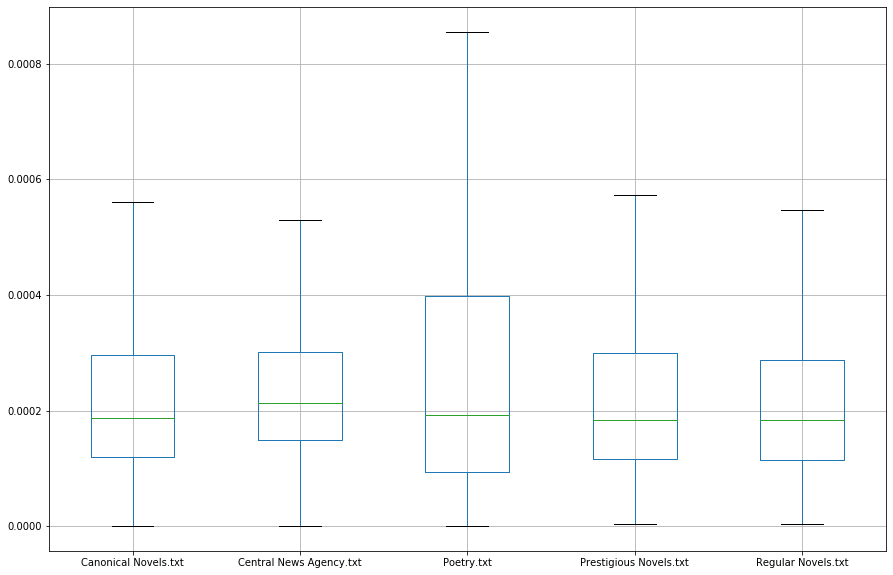

In [10]:
%matplotlib inline
df.boxplot(figsize = (15, 10), showfliers=False)

In [11]:
df.describe()

,Canonical Novels.txt,Central News Agency.txt,Poetry.txt,Prestigious Novels.txt,Regular Novels.txt
count,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,0.000251,0.000243,3.717125e-04,0.000257,0.000246
std,0.000270,0.000141,7.810524e-04,0.000307,0.000247
min,0.000000,0.000000,4.595703e-07,0.000004,0.000003
25%,0.000120,0.000149,9.288890e-05,0.000116,0.000115
50%,0.000187,0.000214,1.920330e-04,0.000184,0.000183
75%,0.000297,0.000301,3.979100e-04,0.000299,0.000288
max,0.008501,0.002298,3.953910e-02,0.007767,0.004886


In [12]:
from scipy import stats
from itertools import combinations
for a, b in list(combinations(df.columns, 2)):
    print(f'{a} : {b}')
    print(stats.ttest_ind(df[a],df[b]))

Canonical Novels.txt : Central News Agency.txt
Ttest_indResult(statistic=2.552955486164272, pvalue=0.010688673312532326)
Canonical Novels.txt : Poetry.txt
Ttest_indResult(statistic=-14.648423341306692, pvalue=2.4547739726797334e-48)
Canonical Novels.txt : Prestigious Novels.txt
Ttest_indResult(statistic=-1.4728912652748583, pvalue=0.14079609596087897)
Canonical Novels.txt : Regular Novels.txt
Ttest_indResult(statistic=1.3942278524406801, pvalue=0.16326429911179666)
Central News Agency.txt : Poetry.txt
Ttest_indResult(statistic=-16.231165951078893, pvalue=7.223306925742566e-59)
Central News Agency.txt : Prestigious Novels.txt
Ttest_indResult(statistic=-4.08177938362255, pvalue=4.486578683061665e-05)
Central News Agency.txt : Regular Novels.txt
Ttest_indResult(statistic=-0.9394757646506924, pvalue=0.34749787648814956)
Poetry.txt : Prestigious Novels.txt
Ttest_indResult(statistic=13.705254034128503, pvalue=1.4707000490328944e-42)
Poetry.txt : Regular Novels.txt
Ttest_indResult(statistic=1

### Comments

- The method seems to be at least working for discriminating between discursive genres (press writing, fiction, poetry)
- Poetry might be expected to be the genre with the most creative writing, however the higher predictability of contemporary North Korean poetry is not really surprising for anyone unfortunate enough to be familiar with it.
- The method shows little significant difference between subgroups of fiction writing. This may be because there's none and all rely, on average, on the same amount of boilerplate. Comparisons between individual writers might be more meaningful. Other possibilities: issues with the fine-tuned model, wrong assumption that the method can be used indiscriminately on any sentence of a text (need to filter at least dialogue, or select for metaphoric sentences with metaphor detection, wrong assumption that the method actually works as intended...)

<hr>

## Code

In [88]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
import logging
import numpy as np
import pickle

logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

tokenizer = AutoTokenizer.from_pretrained("./nkbert-small")
model = AutoModelWithLMHead.from_pretrained("./nkbert-small")

I0930 09:40:56.260138 14160 configuration_utils.py:262] loading configuration file ./nkbert-small\config.json
I0930 09:40:56.263129 14160 configuration_utils.py:300] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 2,
  "vocab_size": 20839
}

I0930 09:40:56.264126 14160 tokenization_utils_base.py:1167] Model name './nkbert-small' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-mask

In [2]:
from konlpy.tag import Komoran
komoran = Komoran()

In [67]:
def compute_word_proba(sequence, word):
    global model, tokenizer
    input_ids = tokenizer.encode(sequence, return_tensors="pt")
    mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]
    token_logits = model(input_ids)[0]
    mask_token_logits = token_logits[0, mask_token_index, :]
    mask_token_logits = torch.softmax(mask_token_logits, dim=1)
    sought_after_token = word
    sought_after_token_id = tokenizer.encode(sought_after_token, add_special_tokens=False, add_prefix_space=True)[0]
    token_score = mask_token_logits[:, sought_after_token_id]
    return token_score.detach().numpy()[0]

def compute_differential_word_proba(sequence, word):
    

def compute_word_by_word_proba(sequence):
    global tokenizer
    global komoran
    pos_filter = ['VV', 'VA', 'NNG', 'NNP', 'MAG', 'NA', 'SN', 'NR', 'XR'] # we only want to predict verbs, nouns and adjectives
    word_dict = {}
    tokenized_sequence = komoran.pos(sequence)
    sequence = ' '.join([token for token, pos in tokenized_sequence])
    for token, pos in tokenized_sequence:
        #print(token, pos)
        if pos in pos_filter:
            masked_sequence = sequence.replace(token, tokenizer.mask_token)
            word_dict[token] = compute_word_proba(masked_sequence, token)
    return word_dict

def geometric_mean(series):
    return np.array(series, dtype=np.float64).prod()**(1.0/len(series))

def compute_sentence_score(sentence):
    return geometric_mean(list(compute_word_by_word_proba(sentence).values()))

def compute_sentence_log_likelihood(sentence):
    return 1/abs(np.mean([np.log(p) for p in list(compute_word_by_word_proba(sentence).values())]))

def compute_sentence_pseudo_perplexity(sentence):
    return np.exp(-1/(np.mean([np.log(p) for p in list(compute_word_by_word_proba(sentence).values())])))

In [118]:
seq = '위대한 김일성장군님의 가르치심을 애타게 기다리는 동지들의 념원을 안고 나는 지금 평양으로 가고있소'
sequence = ' '.join(komoran.morphs(seq))
sequence = sequence.replace('평양', tokenizer.mask_token)


In [119]:
sequence

'위대 하 ㄴ 김일성 장군 님 의 가르치 시 ㅁ 을 애타 게 기다리 는 동지 들 의 념원을 안고 나 는 지금 [MASK] 으로 가 고 있 소'

In [120]:
input_ids = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]
token_logits = model(input_ids)[0]
mask_token_logits = token_logits[0, mask_token_index, :]
predicted_index = torch.argmax(token_logits[0, mask_token_index]).item()
tokenizer.convert_ids_to_tokens([predicted_index])
#mask_token_logits

['하']

In [121]:
for index in torch.topk(mask_token_logits, 10).indices.tolist()[0]:
    print(tokenizer.convert_ids_to_tokens([index]))

['하']
['이']
['.']
['을']
['ㄴ']
['의']
['는']
['다']
['에']
['들']


In [113]:
torch.topk(mask_token_logits, 10).indices.tolist()[0]

[7782, 7096, 54, 7088, 8557, 7095, 5760, 5782, 6896, 5931]

In [46]:
seq = '어린이들이 김대중대통령과 부인에게 꽃다발을 드리였다.'
seq = '김정일동지께서는 전시공로자인 그를 인민군대의 지휘성원으로,조선인민군 장령으로 내세워 주시였으며 전국로병대회를 비롯한 국가행사에 불러 주시고 크나큰 사랑과 은정을 베풀어 주시였다.'
#seq = '오늘 일본은 위험한 침략세력으로 등장하고 있다.'
print(compute_sentence_log_likelihood(seq))
komoran.pos(seq)

6.8321314


[('김정일', 'NNP'),
 ('동지', 'NNP'),
 ('께서', 'JKS'),
 ('는', 'JX'),
 ('전시', 'NNG'),
 ('공로', 'NNG'),
 ('자인', 'NNP'),
 ('그', 'NP'),
 ('를', 'JKO'),
 ('인민군대', 'NNG'),
 ('의', 'JKG'),
 ('지휘', 'NNP'),
 ('성원', 'NNP'),
 ('으로', 'JKB'),
 (',', 'SP'),
 ('조선인민군', 'NNP'),
 ('장령', 'NNG'),
 ('으로', 'JKB'),
 ('내세우', 'VV'),
 ('어', 'EC'),
 ('주시', 'NNG'),
 ('이', 'VCP'),
 ('었', 'EP'),
 ('으며', 'EC'),
 ('전국', 'NNG'),
 ('로', 'JKB'),
 ('병', 'NNG'),
 ('대회', 'NNG'),
 ('를', 'JKO'),
 ('비롯', 'XR'),
 ('하', 'XSA'),
 ('ㄴ', 'ETM'),
 ('국가', 'NNG'),
 ('행사', 'NNG'),
 ('에', 'JKB'),
 ('부르', 'VV'),
 ('어', 'EC'),
 ('주', 'VX'),
 ('시', 'EP'),
 ('고', 'EC'),
 ('크나크', 'VA'),
 ('ㄴ', 'ETM'),
 ('사랑', 'NNG'),
 ('과', 'JC'),
 ('은정', 'NNP'),
 ('을', 'JKO'),
 ('베풀', 'VV'),
 ('어', 'EC'),
 ('주시', 'NNG'),
 ('이', 'VCP'),
 ('었', 'EP'),
 ('다', 'EF'),
 ('.', 'SF')]

In [68]:
seq = '젊은이들은 조심히 김진수의 낯빛을 살피며 한숨을 삼켰다.'
print(compute_sentence_pseudo_perplexity(seq))
seq2 = '젊은이들은 조심히 김진수의 낯빛을 살피며 음식을 삼켰다.'
print(compute_sentence_pseudo_perplexity(seq2))
seq3 = '젊은이들은 조심히 김진수의 낯빛을 살피며 도서관을 삼켰다.'
print(compute_sentence_pseudo_perplexity(seq3))

1.0991429414537783
1.1001011621288694
1.0977751200406303


In [44]:
compute_word_by_word_proba(seq2)

{'젊은이들': 1.877197e-05,
 '은': 0.013749413,
 '조': 0.00045248694,
 '심히': 2.7240125e-05,
 '김진수': 2.714073e-06,
 '의': 0.024211552,
 '낯빛': 4.5080662e-05,
 '을': 0.025879815,
 '살피': 1.7681034e-05,
 '며': 0.003192315,
 '음식': 5.301463e-05,
 '삼키': 1.4393001e-05,
 '었': 0.0097162565,
 '다': 0.018258544,
 '.': 0.028696485}

In [74]:
import os
from tqdm import tqdm


sample_data_path = './samples'
sample_files = [file for file in os.listdir(sample_data_path) if not file.endswith('-tokenized.txt')]
final_results = {}
for file in sample_files:
    with open(os.path.join(sample_data_path, file), 'r', encoding='utf8') as fp:
        sentences = fp.read().splitlines()
    scores = []
    print(file)
    for i, sentence in enumerate(tqdm(sentences[:500])):
        try:
            score = compute_sentence_pseudo_perplexity(sentence.replace('\xa0 ', ''))
            scores.append(score)
        except Exception as e:
            scores.append(np.mean(scores))
            print("Error:", sentence)
            print(e)
            pass
    
    final_results[file] = scores
    
#with open('/project/RDS-FASS-NKBert-RW/samples/final_scores.pkl', 'wb') as fp:
#    pickle.dump(final_results, fp)


Canonical Novels.txt




  0%|                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                        | 1/500 [00:00<05:42,  1.46it/s]

  0%|▋                                                                                                                                                                        | 2/500 [00:00<04:38,  1.79it/s]

  1%|█                                                                                                                                                                        | 3/500 [00:01<03:56,  2.10it/s]

  1%|█▎                                                                                                                                                               

  8%|█████████████                                                                                                                                                           | 39/500 [00:30<06:13,  1.23it/s]

  8%|█████████████▍                                                                                                                                                          | 40/500 [00:31<05:28,  1.40it/s]

  8%|█████████████▊                                                                                                                                                          | 41/500 [00:31<04:50,  1.58it/s]

  8%|██████████████                                                                                                                                                          | 42/500 [00:32<04:45,  1.61it/s]

  9%|██████████████▍                                                                                                                                                    

 16%|██████████████████████████▏                                                                                                                                             | 78/500 [00:53<05:05,  1.38it/s]

 16%|██████████████████████████▌                                                                                                                                             | 79/500 [00:54<05:05,  1.38it/s]

 16%|██████████████████████████▉                                                                                                                                             | 80/500 [00:54<04:17,  1.63it/s]

 16%|███████████████████████████▏                                                                                                                                            | 81/500 [00:54<03:33,  1.96it/s]

 16%|███████████████████████████▌                                                                                                                                       

 24%|███████████████████████████████████████▍                                                                                                                               | 118/500 [01:14<02:26,  2.60it/s]

 24%|███████████████████████████████████████▋                                                                                                                               | 119/500 [01:14<02:10,  2.93it/s]

 24%|████████████████████████████████████████                                                                                                                               | 120/500 [01:15<02:50,  2.23it/s]

 24%|████████████████████████████████████████▍                                                                                                                              | 121/500 [01:15<02:23,  2.64it/s]

 24%|████████████████████████████████████████▋                                                                                                                          

 31%|████████████████████████████████████████████████████▍                                                                                                                  | 157/500 [01:33<02:33,  2.24it/s]

 32%|████████████████████████████████████████████████████▊                                                                                                                  | 158/500 [01:34<02:45,  2.06it/s]

 32%|█████████████████████████████████████████████████████                                                                                                                  | 159/500 [01:34<02:58,  1.91it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                                 | 160/500 [01:35<03:52,  1.46it/s]

 32%|█████████████████████████████████████████████████████▊                                                                                                             

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 196/500 [01:59<02:08,  2.37it/s]

 39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 197/500 [01:59<01:46,  2.86it/s]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                    | 198/500 [02:00<02:19,  2.17it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                    | 199/500 [02:01<03:21,  1.49it/s]

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                        | 235/500 [02:20<02:23,  1.85it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                        | 236/500 [02:21<02:16,  1.94it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 237/500 [02:24<05:44,  1.31s/it]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                       | 238/500 [02:24<04:23,  1.01s/it]

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                   

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 274/500 [02:41<02:18,  1.63it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 275/500 [02:42<02:14,  1.67it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 276/500 [02:42<01:44,  2.14it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 277/500 [02:42<01:28,  2.51it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [03:01<01:32,  2.03it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 314/500 [03:02<02:24,  1.29it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 315/500 [03:03<02:22,  1.29it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 316/500 [03:03<01:57,  1.57it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 353/500 [03:26<00:58,  2.50it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 354/500 [03:26<01:00,  2.39it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 355/500 [03:26<00:57,  2.51it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 356/500 [03:27<00:48,  2.96it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 392/500 [03:52<00:58,  1.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 393/500 [03:53<01:08,  1.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 394/500 [03:53<01:00,  1.76it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 395/500 [03:54<00:47,  2.20it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 431/500 [04:15<01:14,  1.08s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 432/500 [04:15<01:04,  1.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 433/500 [04:16<00:49,  1.36it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 434/500 [04:17<00:58,  1.12it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 470/500 [04:41<00:21,  1.39it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 471/500 [04:42<00:17,  1.65it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 472/500 [04:42<00:13,  2.00it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 473/500 [04:43<00:14,  1.89it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    

Central News Agency.txt




  0%|                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                        | 1/500 [00:02<20:02,  2.41s/it]

  0%|▋                                                                                                                                                                        | 2/500 [00:04<18:32,  2.23s/it]

  1%|█                                                                                                                                                                        | 3/500 [00:04<14:46,  1.78s/it]

  1%|█▎                                                                                                                                                               

  8%|█████████████                                                                                                                                                           | 39/500 [00:38<09:09,  1.19s/it]

  8%|█████████████▍                                                                                                                                                          | 40/500 [00:39<08:26,  1.10s/it]

  8%|█████████████▊                                                                                                                                                          | 41/500 [00:43<15:02,  1.97s/it]

  8%|██████████████                                                                                                                                                          | 42/500 [00:44<13:55,  1.82s/it]

  9%|██████████████▍                                                                                                                                                    

 16%|██████████████████████████▏                                                                                                                                             | 78/500 [01:44<06:54,  1.02it/s]

 16%|██████████████████████████▌                                                                                                                                             | 79/500 [01:45<06:59,  1.00it/s]

 16%|██████████████████████████▉                                                                                                                                             | 80/500 [01:46<05:59,  1.17it/s]

 16%|███████████████████████████▏                                                                                                                                            | 81/500 [01:49<11:16,  1.61s/it]

 16%|███████████████████████████▌                                                                                                                                       

 23%|███████████████████████████████████████                                                                                                                                | 117/500 [02:42<05:50,  1.09it/s]

 24%|███████████████████████████████████████▍                                                                                                                               | 118/500 [02:43<04:51,  1.31it/s]

 24%|███████████████████████████████████████▋                                                                                                                               | 119/500 [02:43<04:37,  1.37it/s]

 24%|████████████████████████████████████████                                                                                                                               | 120/500 [02:45<05:57,  1.06it/s]

 24%|████████████████████████████████████████▍                                                                                                                          

 31%|████████████████████████████████████████████████████                                                                                                                   | 156/500 [03:52<08:55,  1.56s/it]

 31%|████████████████████████████████████████████████████▍                                                                                                                  | 157/500 [03:53<06:50,  1.20s/it]

 32%|████████████████████████████████████████████████████▊                                                                                                                  | 158/500 [03:54<06:25,  1.13s/it]

 32%|█████████████████████████████████████████████████████                                                                                                                  | 159/500 [03:54<05:32,  1.02it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                             

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                     | 195/500 [04:50<08:52,  1.75s/it]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 196/500 [04:53<10:36,  2.09s/it]

 39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 197/500 [04:54<08:39,  1.71s/it]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                    | 198/500 [04:54<07:13,  1.43s/it]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [06:29<03:51,  1.15it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                        | 235/500 [06:29<03:01,  1.46it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                        | 236/500 [06:30<03:11,  1.38it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 237/500 [06:31<03:51,  1.14it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                   

 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 273/500 [07:16<03:37,  1.04it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 274/500 [07:17<02:57,  1.28it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 275/500 [07:20<06:02,  1.61s/it]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 276/500 [07:21<05:00,  1.34s/it]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [08:16<04:09,  1.33s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [08:17<03:33,  1.14s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 314/500 [08:18<04:01,  1.30s/it]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 315/500 [08:20<04:12,  1.37s/it]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 351/500 [09:14<05:35,  2.25s/it]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 352/500 [09:16<04:48,  1.95s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 353/500 [09:16<03:56,  1.61s/it]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 354/500 [09:17<03:00,  1.24s/it]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [10:06<02:19,  1.27s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [10:08<02:27,  1.35s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 392/500 [10:08<01:51,  1.03s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 393/500 [10:09<01:39,  1.08it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 429/500 [11:04<01:20,  1.14s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 430/500 [11:05<01:23,  1.19s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 431/500 [11:05<01:04,  1.07it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 432/500 [11:06<01:01,  1.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 468/500 [11:47<00:39,  1.25s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [11:48<00:31,  1.03s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 470/500 [11:49<00:26,  1.12it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 471/500 [11:50<00:35,  1.22s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     

Poetry.txt




  0%|                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                        | 1/500 [00:00<01:43,  4.82it/s]

  0%|▋                                                                                                                                                                        | 2/500 [00:00<01:39,  5.02it/s]

  1%|█▎                                                                                                                                                                       | 4/500 [00:00<01:18,  6.30it/s]

  1%|██                                                                                                                                                               

 11%|█████████████████▊                                                                                                                                                      | 53/500 [00:08<01:16,  5.81it/s]

 11%|██████████████████▏                                                                                                                                                     | 54/500 [00:08<01:12,  6.16it/s]

 11%|██████████████████▍                                                                                                                                                     | 55/500 [00:08<01:09,  6.41it/s]

 11%|███████████████████▏                                                                                                                                                    | 57/500 [00:08<01:05,  6.78it/s]

 12%|███████████████████▍                                                                                                                                               

 22%|████████████████████████████████████▍                                                                                                                                  | 109/500 [00:15<00:46,  8.47it/s]

 22%|█████████████████████████████████████                                                                                                                                  | 111/500 [00:15<00:40,  9.52it/s]

 23%|█████████████████████████████████████▋                                                                                                                                 | 113/500 [00:15<00:37, 10.21it/s]

 23%|██████████████████████████████████████▍                                                                                                                                | 115/500 [00:16<00:44,  8.59it/s]

 23%|██████████████████████████████████████▋                                                                                                                            

 33%|██████████████████████████████████████████████████████▍                                                                                                                | 163/500 [00:22<00:40,  8.29it/s]

 33%|███████████████████████████████████████████████████████                                                                                                                | 165/500 [00:22<00:41,  8.01it/s]

 33%|███████████████████████████████████████████████████████▊                                                                                                               | 167/500 [00:22<00:38,  8.62it/s]

 34%|████████████████████████████████████████████████████████▍                                                                                                              | 169/500 [00:22<00:34,  9.71it/s]

 34%|█████████████████████████████████████████████████████████                                                                                                          

 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                            | 222/500 [00:29<00:30,  9.08it/s]

 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                            | 224/500 [00:29<00:28,  9.82it/s]

 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                           | 226/500 [00:29<00:30,  9.03it/s]

 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                           | 227/500 [00:29<00:33,  8.11it/s]

 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                      

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 281/500 [00:36<00:26,  8.38it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 282/500 [00:36<00:32,  6.70it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 283/500 [00:36<00:33,  6.43it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 285/500 [00:36<00:30,  7.05it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 333/500 [00:42<00:18,  9.23it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 335/500 [00:42<00:16,  9.80it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 337/500 [00:42<00:15, 10.49it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 339/500 [00:43<00:16,  9.93it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 395/500 [00:50<00:15,  6.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 396/500 [00:50<00:16,  6.49it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 397/500 [00:50<00:14,  7.09it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 399/500 [00:50<00:11,  8.52it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 453/500 [00:57<00:07,  6.66it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 454/500 [00:57<00:06,  6.73it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 455/500 [00:57<00:06,  7.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 457/500 [00:57<00:05,  7.32it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          

Prestigious Novels.txt




  0%|                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                        | 1/500 [00:00<01:57,  4.25it/s]

  0%|▋                                                                                                                                                                        | 2/500 [00:00<02:37,  3.16it/s]

  1%|█                                                                                                                                                                        | 3/500 [00:00<02:18,  3.58it/s]

  1%|█▎                                                                                                                                                               

  8%|█████████████                                                                                                                                                           | 39/500 [00:21<02:48,  2.74it/s]

  8%|█████████████▍                                                                                                                                                          | 40/500 [00:21<02:53,  2.65it/s]

  8%|█████████████▊                                                                                                                                                          | 41/500 [00:22<02:56,  2.60it/s]

  8%|██████████████                                                                                                                                                          | 42/500 [00:22<02:58,  2.57it/s]

  9%|██████████████▍                                                                                                                                                    

 16%|██████████████████████████▏                                                                                                                                             | 78/500 [00:41<02:24,  2.92it/s]

 16%|██████████████████████████▌                                                                                                                                             | 79/500 [00:41<01:59,  3.52it/s]

 16%|██████████████████████████▉                                                                                                                                             | 80/500 [00:41<01:57,  3.58it/s]

 16%|███████████████████████████▏                                                                                                                                            | 81/500 [00:42<02:05,  3.33it/s]

 16%|███████████████████████████▌                                                                                                                                       

 23%|███████████████████████████████████████                                                                                                                                | 117/500 [00:55<02:17,  2.78it/s]

 24%|███████████████████████████████████████▍                                                                                                                               | 118/500 [00:56<03:02,  2.09it/s]

 24%|███████████████████████████████████████▋                                                                                                                               | 119/500 [00:56<02:40,  2.37it/s]

 24%|████████████████████████████████████████                                                                                                                               | 120/500 [00:57<02:52,  2.20it/s]

 24%|████████████████████████████████████████▍                                                                                                                          

 31%|████████████████████████████████████████████████████                                                                                                                   | 156/500 [01:22<07:34,  1.32s/it]

 31%|████████████████████████████████████████████████████▍                                                                                                                  | 157/500 [01:22<06:14,  1.09s/it]

 32%|████████████████████████████████████████████████████▊                                                                                                                  | 158/500 [01:23<05:02,  1.13it/s]

 32%|█████████████████████████████████████████████████████                                                                                                                  | 159/500 [01:23<04:12,  1.35it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                             

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                     | 195/500 [01:40<01:31,  3.33it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 196/500 [01:40<01:28,  3.45it/s]

 39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 197/500 [01:42<03:34,  1.41it/s]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                    | 198/500 [01:42<03:02,  1.66it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 234/500 [02:01<02:28,  1.79it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                        | 235/500 [02:02<01:58,  2.23it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                        | 236/500 [02:02<01:59,  2.22it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 237/500 [02:02<02:00,  2.18it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                   

 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 273/500 [02:21<02:57,  1.28it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 274/500 [02:22<02:43,  1.38it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 275/500 [02:23<02:50,  1.32it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 276/500 [02:23<02:27,  1.52it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 312/500 [02:40<01:59,  1.57it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [02:40<02:10,  1.44it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 314/500 [02:41<01:53,  1.65it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 315/500 [02:42<01:55,  1.60it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 351/500 [02:57<00:52,  2.84it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 352/500 [02:57<00:50,  2.94it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 353/500 [02:58<01:05,  2.25it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 354/500 [02:59<01:11,  2.05it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 390/500 [03:17<00:55,  2.00it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [03:18<00:46,  2.34it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 392/500 [03:21<02:21,  1.31s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 393/500 [03:22<02:22,  1.33s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 430/500 [03:41<00:35,  1.95it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 431/500 [03:41<00:31,  2.22it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 432/500 [03:42<00:31,  2.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 433/500 [03:42<00:35,  1.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [04:04<00:21,  1.41it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 470/500 [04:05<00:18,  1.63it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 471/500 [04:05<00:15,  1.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 472/500 [04:05<00:13,  2.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     

Regular Novels.txt




  0%|                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                        | 1/500 [00:00<03:05,  2.70it/s]

  0%|▋                                                                                                                                                                        | 2/500 [00:00<02:42,  3.06it/s]

  1%|█                                                                                                                                                                        | 3/500 [00:00<02:49,  2.94it/s]

  1%|█▎                                                                                                                                                               

  8%|█████████████                                                                                                                                                           | 39/500 [00:18<06:08,  1.25it/s]

  8%|█████████████▍                                                                                                                                                          | 40/500 [00:18<05:18,  1.44it/s]

  8%|█████████████▊                                                                                                                                                          | 41/500 [00:20<06:46,  1.13it/s]

  8%|██████████████                                                                                                                                                          | 42/500 [00:21<07:26,  1.03it/s]

  9%|██████████████▍                                                                                                                                                    

 16%|██████████████████████████▏                                                                                                                                             | 78/500 [00:36<02:21,  2.98it/s]

 16%|██████████████████████████▌                                                                                                                                             | 79/500 [00:36<02:35,  2.71it/s]

 16%|██████████████████████████▉                                                                                                                                             | 80/500 [00:37<02:22,  2.94it/s]

 16%|███████████████████████████▏                                                                                                                                            | 81/500 [00:37<02:22,  2.95it/s]

 16%|███████████████████████████▌                                                                                                                                       

 23%|███████████████████████████████████████                                                                                                                                | 117/500 [00:53<02:09,  2.95it/s]

 24%|███████████████████████████████████████▍                                                                                                                               | 118/500 [00:53<02:14,  2.84it/s]

 24%|███████████████████████████████████████▋                                                                                                                               | 119/500 [00:54<03:12,  1.98it/s]

 24%|████████████████████████████████████████                                                                                                                               | 120/500 [00:54<02:39,  2.38it/s]

 24%|████████████████████████████████████████▍                                                                                                                          

 31%|████████████████████████████████████████████████████                                                                                                                   | 156/500 [01:13<03:18,  1.73it/s]

 31%|████████████████████████████████████████████████████▍                                                                                                                  | 157/500 [01:14<02:42,  2.11it/s]

 32%|████████████████████████████████████████████████████▊                                                                                                                  | 158/500 [01:14<02:42,  2.10it/s]

 32%|█████████████████████████████████████████████████████                                                                                                                  | 159/500 [01:15<03:29,  1.62it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                             

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 196/500 [01:36<02:20,  2.16it/s]

 39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 197/500 [01:38<03:16,  1.54it/s]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                    | 198/500 [01:38<03:33,  1.42it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                    | 199/500 [01:39<03:20,  1.50it/s]

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                        | 235/500 [01:59<03:07,  1.42it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                        | 236/500 [01:59<02:39,  1.65it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 237/500 [01:59<02:13,  1.97it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                       | 238/500 [02:00<01:53,  2.32it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                   

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 274/500 [02:18<02:33,  1.47it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 275/500 [02:19<02:04,  1.81it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 276/500 [02:19<01:47,  2.08it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 277/500 [02:19<01:30,  2.47it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 313/500 [02:33<01:12,  2.57it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 314/500 [02:33<01:04,  2.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 315/500 [02:34<01:12,  2.55it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 316/500 [02:34<01:04,  2.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 352/500 [02:52<01:31,  1.62it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 353/500 [02:52<01:15,  1.96it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 354/500 [02:53<01:33,  1.56it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 355/500 [02:53<01:15,  1.92it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 391/500 [03:11<00:41,  2.65it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 392/500 [03:11<00:51,  2.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 393/500 [03:12<00:40,  2.65it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 394/500 [03:12<00:42,  2.50it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 430/500 [03:25<00:24,  2.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 431/500 [03:25<00:27,  2.52it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 432/500 [03:26<00:27,  2.48it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 433/500 [03:26<00:25,  2.66it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 469/500 [03:43<00:12,  2.52it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 470/500 [03:44<00:11,  2.59it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 472/500 [03:44<00:10,  2.68it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 473/500 [03:45<00:11,  2.28it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    

In [75]:
import pandas as pd
df = pd.DataFrame(final_results)
df

,Canonical Novels.txt,Central News Agency.txt,Poetry.txt,Prestigious Novels.txt,Regular Novels.txt
0,1.116897,1.122821,1.105483,1.099111,1.114546
1,1.133932,1.118004,1.104214,1.115412,1.124561
2,1.118937,1.133697,1.158413,1.138110,1.110446
3,1.110223,1.132402,1.109843,1.125330,1.111056
4,1.123942,1.117223,1.142246,1.131596,1.119539
...,...,...,...,...,...
495,1.123265,1.126618,1.142252,1.129221,1.126308
496,1.126989,1.122723,1.092579,1.115800,1.115259
497,1.122507,1.120003,1.152537,1.113027,1.117912
498,1.116687,1.122102,1.137240,1.140732,1.125889


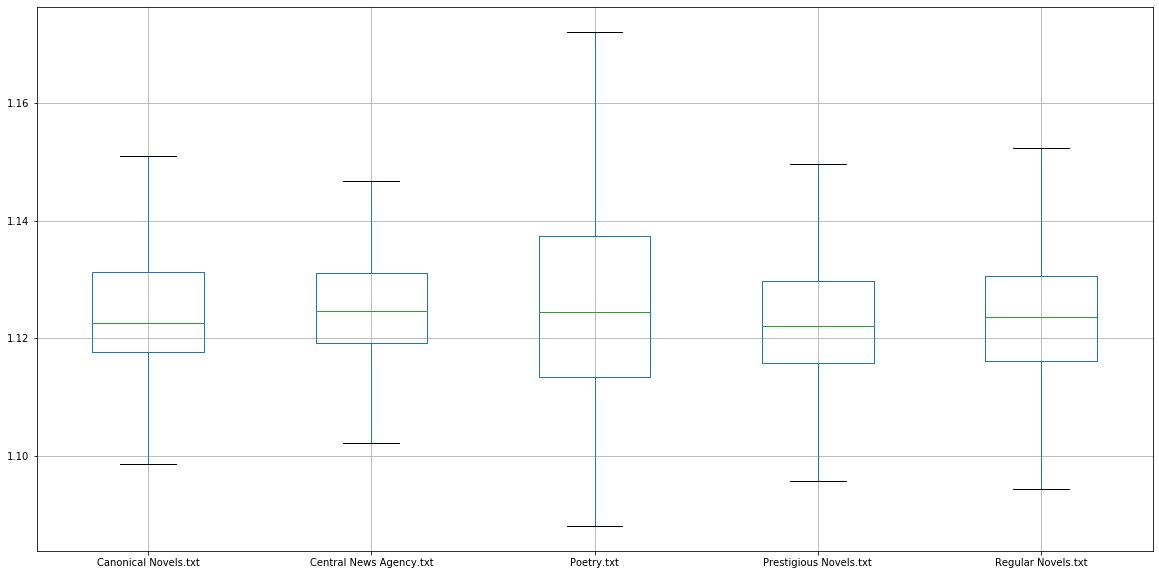

In [76]:
%matplotlib inline
df.boxplot(figsize = (20, 10), showfliers=False)

In [77]:
df.describe()

,Canonical Novels.txt,Central News Agency.txt,Poetry.txt,Prestigious Novels.txt,Regular Novels.txt
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.124973,1.125396,1.127242,1.123872,1.124361
std,0.012693,0.009046,0.021223,0.012919,0.012500
min,1.098674,1.102137,1.088074,1.088356,1.082380
25%,1.117688,1.119251,1.113510,1.115789,1.116123
50%,1.122588,1.124711,1.124474,1.122161,1.123732
75%,1.131274,1.131109,1.137424,1.129740,1.130674
max,1.236064,1.170146,1.261431,1.184718,1.189405


In [78]:
from scipy import stats
from itertools import combinations
for a, b in list(combinations(df.columns, 2)):
    print(f'{a} : {b}')
    print(stats.ttest_ind(df[a],df[b]))

Canonical Novels.txt : Central News Agency.txt
Ttest_indResult(statistic=-0.6080487648064266, pvalue=0.5432934761357201)
Canonical Novels.txt : Poetry.txt
Ttest_indResult(statistic=-2.052320802621596, pvalue=0.04039889228168309)
Canonical Novels.txt : Prestigious Novels.txt
Ttest_indResult(statistic=1.3592662072725072, pvalue=0.17436930719383978)
Canonical Novels.txt : Regular Novels.txt
Ttest_indResult(statistic=0.7672642553132089, pvalue=0.44310588953255037)
Central News Agency.txt : Poetry.txt
Ttest_indResult(statistic=-1.789077468479009, pvalue=0.07390551897446072)
Central News Agency.txt : Prestigious Novels.txt
Ttest_indResult(statistic=2.1618348493979864, pvalue=0.030868037803256265)
Central News Agency.txt : Regular Novels.txt
Ttest_indResult(statistic=1.5000725767258454, pvalue=0.1339118744014194)
Poetry.txt : Prestigious Novels.txt
Ttest_indResult(statistic=3.033463693634333, pvalue=0.0024801847411377834)
Poetry.txt : Regular Novels.txt
Ttest_indResult(statistic=2.61545415483